In [158]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
from circadian.models import DynamicalTrajectory, Skeldon23

In [159]:
data_location = '../data/light_schedules/'
time = np.load(data_location + 'time.npy')
regular_light = np.load(data_location + 'regular_light.npy')
chang14_ebook_first_light = np.load(data_location + 'chang14_ebook_first_light.npy')
chang14_ebook_second_light = np.load(data_location + 'chang14_ebook_second_light.npy')

In [160]:
# Load summary information about the simulations
# 61 out of 125 simulations had a sleep duration above 6.5 hours
selected_parameters = pd.read_csv('../data/parameter_exploration/selected_parameters.csv', index_col=0)

In [161]:
def calculate_sleep_onset(time, data, simulation_condition):
    sleep = data[f'{simulation_condition}_sleep']
    sleep_onset_idx = np.where(np.diff(sleep) == 1)[0]
    sleep_onset_time = time[sleep_onset_idx][:-1] # Ignore the last day
    return sleep_onset_time

def calculate_sleep_duration(time, data, simulation_condition):
    sleep = data[f'{simulation_condition}_sleep']
    sleep_onset_idx = np.where(np.diff(sleep) == 1)[0][:-1] # Ignore the last onset
    sleep_offset_idx = np.where(np.diff(sleep) == -1)[0][1:] # Ignore the first offset
    sleep_duration = time[sleep_offset_idx] - time[sleep_onset_idx]
    return sleep_duration

def calculate_cbtmin(time, data, model, simulation_condition):
    trajectory = DynamicalTrajectory(time, data[f'{simulation_condition}_trajectory_states'])
    cbtmin = model.cbt(trajectory)[:-1] # Ignore the last day
    return cbtmin

In [162]:
DAILY_CONDITION_EBOOK_FIRST = [
    'None',
    'eBook', 'eBook', 'eBook', 'eBook', 'eBook',
    'None',
    'Book', 'Book', 'Book', 'Book', 'Book',
    'None',
]
DAILY_CONDITION_EBOOK_SECOND = [
    'None',
    'Book', 'Book', 'Book', 'Book', 'Book',
    'None',
    'eBook', 'eBook', 'eBook', 'eBook', 'eBook',
    'None',
]

DAILY_CONDITION_CHOICE = {
    'regular': ['None'] * 13,
    'ebook_first': DAILY_CONDITION_EBOOK_FIRST,
    'ebook_second': DAILY_CONDITION_EBOOK_SECOND,
}

def process_condition(idx, time, data, model, condition):
    data_subset = {}
    sleep_onset = calculate_sleep_onset(time, data, condition)
    sleep_duration = calculate_sleep_duration(time, data, condition)
    cbtmin = calculate_cbtmin(time, data, model, condition)
    min_length = min(len(sleep_onset), len(cbtmin))
    sleep_onset = sleep_onset[:min_length]
    cbtmin = cbtmin[:min_length]
    days = np.arange(1, min_length + 1)
    daily_correction = np.arange(1, min_length + 1) * 24 - 24
    sleep_onset = sleep_onset - daily_correction
    cbtmin = cbtmin - daily_correction
    daily_condition = DAILY_CONDITION_CHOICE[condition]
    data_subset = {
        'idx': idx,
        'day': days,
        'daily_condition': daily_condition[:min_length],
        'simulation_condition': condition,
        'sleep_onset': sleep_onset,
        'sleep_duration': sleep_duration[:min_length],
        'cbtmin': cbtmin,
    }
    return data_subset

In [163]:
# Calculate simulation features
model = Skeldon23()
simulation_features = pd.DataFrame()
for idx in selected_parameters.index:
    data = np.load(f'../data/skeldon23_on_chang14/chang14_simulation_{idx}.npz', 
                    allow_pickle=True)
    data_subset = process_condition(idx, time, data, model, 'regular')

    simulation_features = pd.concat([simulation_features, pd.DataFrame(data_subset)])

    for reading_condition in ['ebook_first', 'ebook_second']:
        data_subset = process_condition(idx, time, data, model, reading_condition)
        simulation_features = pd.concat([simulation_features, pd.DataFrame(data_subset)])

## Sleep pressure example plot

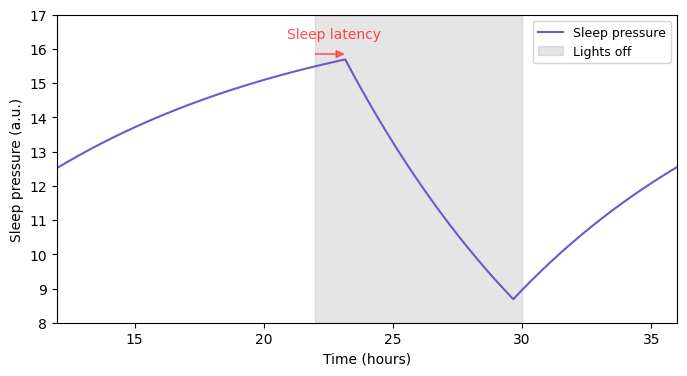

In [164]:
labels = ['Regular', 'eBook first', 'eBook second']
condition = 'ebook_first'
idx = selected_parameters.index[0]
daily_correction = 5*24
day_6_idx = np.where((time < 7*24) & (time > 5*24))[0]
data = np.load(f'../data/skeldon23_on_chang14/chang14_simulation_{idx}.npz', 
               allow_pickle=True)
trajectory = data[f'{condition}_trajectory_states']
x = time[day_6_idx] - daily_correction

fig, ax = plt.subplots(figsize=(8, 4))
pressure = ax.plot(x, trajectory[day_6_idx, 3], label='Sleep pressure',
                   color='slateblue')
ax.axvspan(22, 6 + 24, color='black', alpha=0.1, label='Lights off')
ax.set_xlim(12, 36)
ax.set_ylabel('Sleep pressure (a.u.)')
ax.set_xlabel('Time (hours)')
ax.arrow(22.0, 15.85, 1.1, 0, head_width=0.2, head_length=0.3, fc='r', ec='r',
         length_includes_head=True,
         alpha=0.5)
ax.set_ylim(8, 17)
ax.text(20.9, 16.3, 'Sleep latency', fontsize=10, color='red', alpha=0.7)
ax.legend(fontsize=9)

plt.show()

# Sleep latency histogram comparison

In [165]:
# Sleep latency at last condition day
scheduled_bedtime = 22.0
possible_days = (simulation_features['day'] == 6) | (simulation_features['day'] == 12)
book_sleep_onset = simulation_features[possible_days & (simulation_features['daily_condition'] == 'Book')]['sleep_onset']
book_sleep_latency = book_sleep_onset - scheduled_bedtime
book_sleep_latency = book_sleep_latency.to_numpy() * 60 # Convert to minutes

ebook_sleep_onset = simulation_features[possible_days & (simulation_features['daily_condition'] == 'eBook')]['sleep_onset']
ebook_sleep_latency = ebook_sleep_onset - scheduled_bedtime
ebook_sleep_latency = ebook_sleep_latency.to_numpy() * 60 # Convert to minutes

df = pd.DataFrame({
    'sleep_latency': np.concatenate([book_sleep_latency, ebook_sleep_latency]),
    'condition': ['Book'] * len(book_sleep_latency) + ['eBook'] * len(ebook_sleep_latency),
})

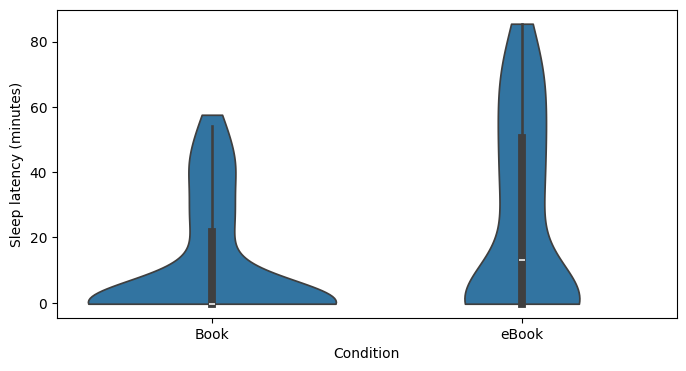

In [166]:
fig, ax = plt.subplots(figsize=(8, 4))
palette = {'Book': 'lightcoral', 'eBook': 'mediumpurple'}
sns.violinplot(x='condition', y='sleep_latency', data=df, ax=ax,
               cut=0, inner='box')
ax.set_ylabel('Sleep latency (minutes)')
ax.set_xlabel('Condition')
plt.show()

## Sleep duration

In [153]:
possible_days = (simulation_features['day'] == 6) | (simulation_features['day'] == 12)
book_sleep_duration = simulation_features[possible_days & (simulation_features['daily_condition'] == 'Book')]['sleep_duration']
ebook_sleep_duration = simulation_features[possible_days & (simulation_features['daily_condition'] == 'eBook')]['sleep_duration']

df = pd.DataFrame({
    'sleep_duration': np.concatenate([book_sleep_duration, ebook_sleep_duration]),
    'condition': ['Book'] * len(book_sleep_duration) + ['eBook'] * len(ebook_sleep_duration),
})

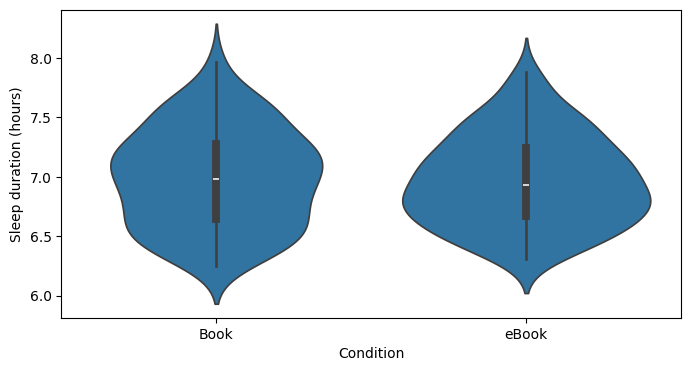

In [155]:
# seabron violin
fig, ax = plt.subplots(figsize=(8, 4))

sns.violinplot(x='condition', y='sleep_duration', data=df, ax=ax,
               inner='box')
ax.set_ylabel('Sleep duration (hours)')
ax.set_xlabel('Condition')
plt.show()

In [20]:
simulation_features

,idx,day,daily_condition,simulation_condition,sleep_onset,cbtmin
0,4,1,None,regular,23.300,3.500
1,4,2,None,regular,23.300,3.500
2,4,3,None,regular,23.300,3.495
3,4,4,None,regular,23.300,3.495
4,4,5,None,regular,23.300,3.495
...,...,...,...,...,...,...
8,123,9,eBook,ebook_second,23.015,2.835
9,123,10,eBook,ebook_second,23.045,2.880
10,123,11,eBook,ebook_second,23.060,2.920
11,123,12,eBook,ebook_second,23.075,2.950
